# Capital asset pricing model

### helps to calculate expected return of the stock


#### The goal of the CAPM formula is to evaluate whether a stock is fairly valued when its risk and the time value of money are compared to its expected return.

# Utils

In [ ]:
!pip install -U yfinance requests pandas fredapi

In [88]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import requests
import io

from fredapi import Fred
from datetime import datetime, timedelta

In [179]:
def three_month_yield_us_tresuries(start, end):
    fred = Fred(api_key='')
    return pd.DataFrame(fred.get_series('DGS3MO', observation_start=start, observation_end=end), columns=['value'])

def capm(risk_free_rate, beta, expected_return):
    return risk_free_rate + beta * (expected_return - risk_free_rate)

# Inputs

In [220]:
market = "SPY"
stock = "AAPL"
historical_data_years = 5
tickers = [market, stock]

start = datetime.now() - timedelta(days = 365 * historical_data_years)
end = datetime.now() - timedelta(days = 365)
print('Start date:', start.strftime("%d/%m/%Y"), 'End date:', end.strftime("%d/%m/%Y"))

Start date: 07/02/2017 End date: 06/02/2021


# Stock and market price right now

In [221]:
live_prices = yf.download(tickers=tickers, period='1d', interval='1d')
live_prices = [live_prices['Adj Close'][ticker][0] for ticker in tickers]

print("Risk free rate:", risk_free_rate)
print("Adj Close stock price now:", dict(zip(tickers, live_prices)))

[*********************100%***********************]  2 of 2 completed
Risk free rate: 0.013344500000000002
Adj Close stock price now: {'SPY': 448.70001220703125, 'AAPL': 172.38999938964844}


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,tickers,starting_date,observations(days),annual_return_avg,daily_return_avg,variance,std
0,SPY,02/06/2017,1008,17.13%,0.07%,4.08%,20.20%
1,AAPL,02/06/2017,1008,42.43%,0.17%,10.20%,31.93%


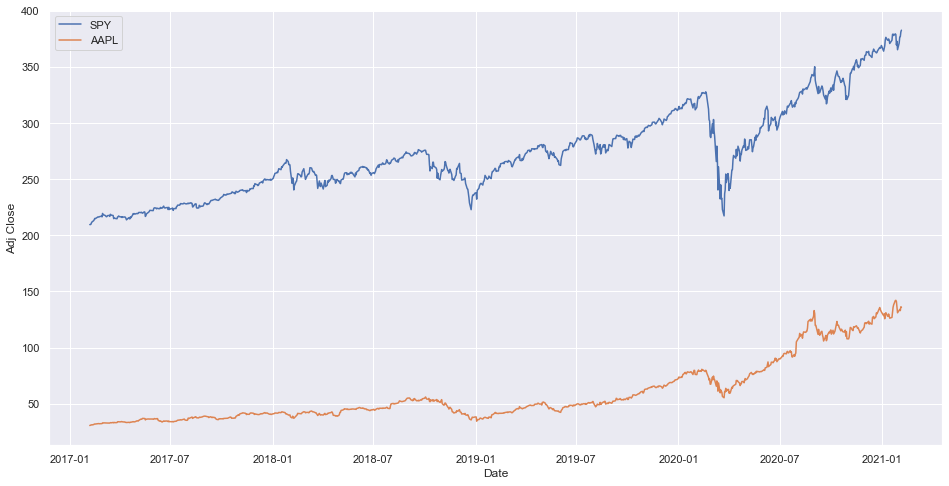

In [222]:
stock_info = {
    'tickers': tickers, 
    'starting_date': [], 
    'observations(days)': [], 
    'annual_return_avg': [], 
    'daily_return_avg': [], 
    'variance': [],
}
price_hist = {}

sns.set(rc = {'figure.figsize': (16,8)})

for ticker in tickers:
    tmp = yf.download(ticker, start=start, end=end)
    tmp['daily_change'] = tmp['Adj Close'].pct_change()
    stock_info['starting_date'].append(tmp.index[0])
    stock_info['annual_return_avg'].append(tmp['daily_change'].mean() * 252)
    stock_info['daily_return_avg'].append(tmp['daily_change'].mean())
    stock_info['variance'].append(tmp['daily_change'].var() * 252)
    stock_info['observations(days)'].append(len(tmp))
    price_hist[ticker] = tmp['daily_change']
    sns.lineplot(x=tmp.index, y='Adj Close', data=tmp, markers=True, label=ticker)
    
price_hist = pd.DataFrame.from_dict(price_hist)

three_month_yield = three_month_yield_us_tresuries(start, end)
risk_free_rate = three_month_yield['value'].mean() / 100

df = pd.DataFrame.from_dict(stock_info)
df['std'] = df['variance'].apply(np.sqrt)
df['starting_date'] = df['starting_date'].dt.strftime('%m/%d/%Y')
df.style.format({
    'annual_return_avg': '{:,.2%}'.format,
    'daily_return_avg': '{:,.2%}'.format,
    'variance': '{:,.2%}'.format, 
    'std': '{:,.2%}'.format},
)

In [223]:
expected_returns = (price_hist * 100).round(2)
expected_returns

,SPY,AAPL
Date,,
2017-02-06,NaN,NaN
2017-02-07,0.00,0.95
2017-02-08,0.13,0.39
2017-02-09,0.59,0.72
2017-02-10,0.39,-0.23
...,...,...
2021-02-01,1.66,1.65
2021-02-02,1.41,0.63
2021-02-03,0.08,-0.78


#### Beta might be considered as a slope of the line (k param) in line equation:
$y = kx + b$

In [224]:
beta = (price_hist.cov() / price_hist[market].var()).loc[stock, market]
beta

1.221821524215263

## CAPM

$ER_i=R_f+\beta_i(ER_m-R_f)$, where

- $ER_i$ - expected return of investment
- $R_i$ - risk free rate
- $B_i$ - beta of the investment
- $(ER_m-R_f)$ - market risk premium 

In [225]:
annual_return = df.where(df['tickers'] == market).dropna()['annual_return_avg'][0]
CAPM_stock = capm(risk_free_rate, beta, annual_return)
print("CAPM of stock:", CAPM_stock)
print("Expected stock price in a year:", dict(zip(tickers, live_prices))[stock] * (1 + CAPM_stock))

CAPM of stock: 0.20630146642671748
Expected stock price in a year: 207.95430906103385


# References

- https://www.investopedia.com/terms/c/capm.asp

- https://fred.stlouisfed.org/series/DGS3MO
